In [1]:
# Import common libraries
import sys
import gym
import numpy as np
import matplotlib.pyplot as plt

# Set plotting options
%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

# Create an environment
env = gym.make('Acrobot-v1')
env.seed(505);


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/jim/gym/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [2]:
def create_tiling_grid(low, high, bins=(10, 10), offsets=(0.0, 0.0)):
    grid = [np.linspace(low[dim], high[dim], bins[dim] + 1)[1:-1] + offsets[dim] for dim in range(len(bins))]
    print("Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>")
    for l, h, b, o, splits in zip(low, high, bins, offsets, grid):
        print("    [{}, {}] / {} + ({}) => {}".format(l, h, b, o, splits))
    return grid
    return grid


In [3]:
def create_tilings(low, high, tiling_specs):
    return [create_tiling_grid(low, high, bins, offsets) for bins, offsets in tiling_specs]

In [4]:
def discretize(sample, grid):
    return tuple(int(np.digitize(s, g)) for s, g in zip(sample, grid))  # apply along each dimension


def tile_encode(sample, tilings, flatten=False):
    encoded_sample = [discretize(sample, grid) for grid in tilings]
    return np.concatenate(encoded_sample) if flatten else encoded_sample

In [5]:
from matplotlib.patches import Rectangle

def visualize_encoded_samples(samples, encoded_samples, tilings, low=None, high=None):
    """Visualize samples by activating the respective tiles."""
    samples = np.array(samples)  # for ease of indexing

    # Show tiling grids
    ax = visualize_tilings(tilings)
    
    # If bounds (low, high) are specified, use them to set axis limits
    if low is not None and high is not None:
        ax.set_xlim(low[0], high[0])
        ax.set_ylim(low[1], high[1])
    else:
        # Pre-render (invisible) samples to automatically set reasonable axis limits, and use them as (low, high)
        ax.plot(samples[:, 0], samples[:, 1], 'o', alpha=0.0)
        low = [ax.get_xlim()[0], ax.get_ylim()[0]]
        high = [ax.get_xlim()[1], ax.get_ylim()[1]]

    # Map each encoded sample (which is really a list of indices) to the corresponding tiles it belongs to
    tilings_extended = [np.hstack((np.array([low]).T, grid, np.array([high]).T)) for grid in tilings]  # add low and high ends
    tile_centers = [(grid_extended[:, 1:] + grid_extended[:, :-1]) / 2 for grid_extended in tilings_extended]  # compute center of each tile
    tile_toplefts = [grid_extended[:, :-1] for grid_extended in tilings_extended]  # compute topleft of each tile
    tile_bottomrights = [grid_extended[:, 1:] for grid_extended in tilings_extended]  # compute bottomright of each tile

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    for sample, encoded_sample in zip(samples, encoded_samples):
        for i, tile in enumerate(encoded_sample):
            # Shade the entire tile with a rectangle
            topleft = tile_toplefts[i][0][tile[0]], tile_toplefts[i][1][tile[1]]
            bottomright = tile_bottomrights[i][0][tile[0]], tile_bottomrights[i][1][tile[1]]
            ax.add_patch(Rectangle(topleft, bottomright[0] - topleft[0], bottomright[1] - topleft[1],
                                   color=colors[i], alpha=0.33))

            # In case sample is outside tile bounds, it may not have been highlighted properly
            if any(sample < topleft) or any(sample > bottomright):
                # So plot a point in the center of the tile and draw a connecting line
                cx, cy = tile_centers[i][0][tile[0]], tile_centers[i][1][tile[1]]
                ax.add_line(Line2D([sample[0], cx], [sample[1], cy], color=colors[i]))
                ax.plot(cx, cy, 's', color=colors[i])
    
    # Finally, plot original samples
    ax.plot(samples[:, 0], samples[:, 1], 'o', color='r')

    ax.margins(x=0, y=0)  # remove unnecessary margins
    ax.set_title("Tile-encoded samples")
    return ax

In [6]:
class QTable:
    """Simple Q-table."""

    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.q_table = np.zeros(shape=(self.state_size + (self.action_size,)))
        print("QTable(): size =", self.q_table.shape)


class TiledQTable:
    """Composite Q-table with an internal tile coding scheme."""
    
    def __init__(self, low, high, tiling_specs, action_size):
        self.tilings = create_tilings(low, high, tiling_specs)
        self.state_sizes = [tuple(len(splits)+1 for splits in tiling_grid) for tiling_grid in self.tilings]
        self.action_size = action_size
        self.q_tables = [QTable(state_size, self.action_size) for state_size in self.state_sizes]
        print("TiledQTable(): no. of internal tables = ", len(self.q_tables))
    
    def get(self, state, action):
        encoded_state = tile_encode(state, self.tilings)
        value = 0.0
        for idx, q_table in zip(encoded_state, self.q_tables):
            value += q_table.q_table[tuple(idx + (action,))]
        value /= len(self.q_tables)
        return value
    
    def update(self, state, action, value, alpha=0.1):
        encoded_state = tile_encode(state, self.tilings)
        for idx, q_table in zip(encoded_state, self.q_tables):
            value_ = q_table.q_table[tuple(idx + (action,))]  # current value
            q_table.q_table[tuple(idx + (action,))] = alpha * value + (1.0 - alpha) * value_


In [7]:
class QLearningAgent:
    """Q-Learning agent that can act on a continuous state space by discretizing it."""

    def __init__(self, env, tq, alpha=0.02, gamma=0.99,
                 epsilon=1.0, epsilon_decay_rate=0.9995, min_epsilon=.01, seed=0):
        """Initialize variables, create grid for discretization."""
        # Environment info
        self.env = env
        self.tq = tq 
        self.state_sizes = tq.state_sizes           # list of state sizes for each tiling
        self.action_size = self.env.action_space.n  # 1-dimensional discrete action space
        self.seed = np.random.seed(seed)
        print("Environment:", self.env)
        print("State space sizes:", self.state_sizes)
        print("Action space size:", self.action_size)
        
        # Learning parameters
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = self.initial_epsilon = epsilon  # initial exploration rate
        self.epsilon_decay_rate = epsilon_decay_rate   # how quickly should we decrease epsilon
        self.min_epsilon = min_epsilon

    def reset_episode(self, state):
        """Reset variables for a new episode."""
        # Gradually decrease exploration rate
        self.epsilon *= self.epsilon_decay_rate
        self.epsilon = max(self.epsilon, self.min_epsilon)
        
        self.last_state = state
        Q_s = [self.tq.get(state, action) for action in range(self.action_size)]
        self.last_action = np.argmax(Q_s)
        return self.last_action
    
    def reset_exploration(self, epsilon=None):
        """Reset exploration rate used when training."""
        self.epsilon = epsilon if epsilon is not None else self.initial_epsilon

    def act(self, state, reward=None, done=None, mode='train'):
        """Pick next action and update internal Q table (when mode != 'test')."""
        Q_s = [self.tq.get(state, action) for action in range(self.action_size)]
        # Pick the best action from Q table
        greedy_action = np.argmax(Q_s)
        if mode == 'test':
            # Test mode: Simply produce an action
            action = greedy_action
        else:
            # Train mode (default): Update Q table, pick next action
            # Note: We update the Q table entry for the *last* (state, action) pair with current state, reward
            value = reward + self.gamma * max(Q_s)
            self.tq.update(self.last_state, self.last_action, value, self.alpha)

            # Exploration vs. exploitation
            do_exploration = np.random.uniform(0, 1) < self.epsilon
            if do_exploration:
                # Pick a random action
                action = np.random.randint(0, self.action_size)
            else:
                # Pick the greedy action
                action = greedy_action

        # Roll over current state, action for next step
        self.last_state = state
        self.last_action = action
        return action

In [8]:
from matplotlib.lines import Line2D

def visualize_tilings(tilings):
    """Plot each tiling as a grid."""
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    linestyles = ['-', '--', ':']
    legend_lines = []

    fig, ax = plt.subplots(figsize=(10, 10))
    for i, grid in enumerate(tilings):
        for x in grid[0]:
            l = ax.axvline(x=x, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)], label=i)
        for y in grid[1]:
            l = ax.axhline(y=y, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)])
        legend_lines.append(l)
    ax.grid('off')
    ax.legend(legend_lines, ["Tiling #{}".format(t) for t in range(len(legend_lines))], facecolor='white', framealpha=0.9)
    ax.set_title("Tilings")
    return ax  # return Axis object to draw on later, if needed


Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 5 + (-0.6956830161208136) => [-1.296 -0.896 -0.496 -0.096]
    [-1.0, 1.0] / 5 + (-0.2405236949910865) => [-0.841 -0.441 -0.041  0.359]
    [-1.0, 1.0] / 5 + (-0.0034208497074357247) => [-0.603 -0.203  0.197  0.597]
    [-1.0, 1.0] / 5 + (-0.046205420378123474) => [-0.646 -0.246  0.154  0.554]
    [-12.566370964050293, 12.566370964050293] / 5 + (11.258506125878256) => [ 3.719  8.745 13.772 18.798]
    [-28.274333953857422, 28.274333953857422] / 5 + (-18.20925735566587) => [-35.174 -23.864 -12.554  -1.245]
Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 5 + (-0.2666666805744171) => [-0.867 -0.467 -0.067  0.333]
    [-1.0, 1.0] / 5 + (-0.2666666805744171) => [-0.867 -0.467 -0.067  0.333]
    [-1.0, 1.0] / 5 + (-0.2666666805744171) => [-0.867 -0.467 -0.067  0.333]
    [-1.0, 1.0] / 5 + (-0.2666666805744171) => [-0.867 -0.467 -0.067  0.333]
    [-12.566370964050293, 12.566370964050293] /

/home/jim/anaconda2/envs/deep-learning/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


array([-6.957e-01, -2.405e-01, -3.421e-03, -4.621e-02,  1.126e+01, -1.821e+01])

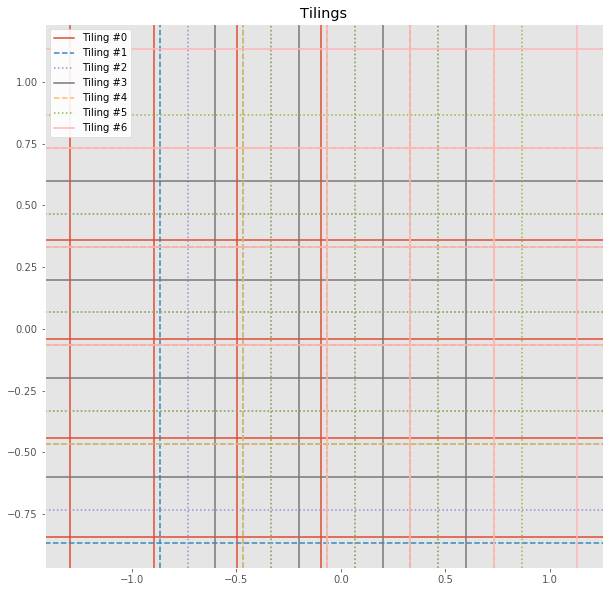

In [9]:
import random
n_bins = 5
bins = tuple([n_bins]*env.observation_space.shape[0])
offset_pos = (env.observation_space.high - env.observation_space.low)/(3*n_bins)

# choose the offset randomly
rand = np.zeros(6)
for i in range(0, len(env.observation_space.low)):
    rand[i] = random.uniform(env.observation_space.low[i], env.observation_space.high[i])


tiling_specs = [(bins, rand),
                (bins, -offset_pos*2),
                (bins, -offset_pos),
                (bins, tuple([0.0]*env.observation_space.shape[0])),
                (bins, offset_pos),
                (bins, offset_pos*2),
                (bins, offset_pos*4)]

tq = TiledQTable(env.observation_space.low, 
                 env.observation_space.high, 
                 tiling_specs, 
                 env.action_space.n)
agent = QLearningAgent(env, tq)

tilings = create_tilings(env.observation_space.low, env.observation_space.high, tiling_specs)
visualize_tilings(tilings);

rand

In [10]:
def run(agent, env, num_episodes=20000, mode='train'):
    """Run agent in given reinforcement learning environment and return scores."""
    scores = []
    max_avg_score = -np.inf
    for i_episode in range(1, num_episodes+1):
        # Initialize episode
        state = env.reset()
        action = agent.reset_episode(state)
        total_reward = 0
        done = False

        # Roll out steps until done
        while not done:
            state, reward, done, info = env.step(action)
            total_reward += reward
            action = agent.act(state, reward, done, mode)

        # Save final score
        scores.append(total_reward)

        # Print episode stats
        if mode == 'train':
            if len(scores) > 100:
                avg_score = np.mean(scores[-100:])
                if avg_score > max_avg_score:
                    max_avg_score = avg_score
            if i_episode % 100 == 0:
                print("\rEpisode {}/{} | Max Average Score: {}".format(i_episode, num_episodes, max_avg_score), end="")
                sys.stdout.flush()
    return scores

scores_7_tilings = run(agent, env)

Episode 20000/20000 | Max Average Score: -181.51

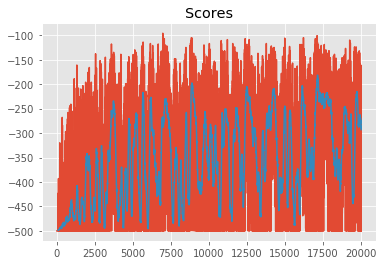

In [11]:
import pandas as pd
def plot_scores(scores, rolling_window=100):
    """Plot scores and optional rolling mean using specified window."""
    plt.plot(scores); plt.title("Scores");
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean);
    return rolling_mean

rolling_mean = plot_scores(scores_7_tilings)

In [12]:
def run(agent, env, num_episodes=200000, mode='train'):
    """Run agent in given reinforcement learning environment and return scores."""
    scores = []
    max_avg_score = -np.inf
    for i_episode in range(1, num_episodes+1):
        # Initialize episode
        state = env.reset()
        action = agent.reset_episode(state)
        total_reward = 0
        done = False

        # Roll out steps until done
        while not done:
            state, reward, done, info = env.step(action)
            total_reward += reward
            action = agent.act(state, reward, done, mode)

        # Save final score
        scores.append(total_reward)

        # Print episode stats
        if mode == 'train':
            if len(scores) > 100:
                avg_score = np.mean(scores[-100:])
                if avg_score > max_avg_score:
                    max_avg_score = avg_score
            if i_episode % 100 == 0:
                print("\rEpisode {}/{} | Max Average Score: {}".format(i_episode, num_episodes, max_avg_score), end="")
                sys.stdout.flush()
    return scores

scores_7_tilings_rand_200000 = run(agent, env)

Episode 200000/200000 | Max Average Score: -101.94

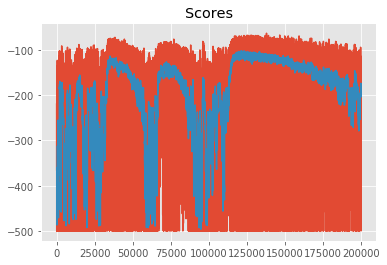

In [14]:
import pandas as pd
def plot_scores(scores, rolling_window=100):
    """Plot scores and optional rolling mean using specified window."""
    plt.plot(scores); plt.title("Scores");
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean);
    return rolling_mean

rolling_mean = plot_scores(scores_7_tilings_rand_200000)